# Local Spatial Autocorrelation Analysis



In [1]:
%matplotlib inline
import pysal as ps
import pandas as pd
import numpy as np
from pysal.contrib.viz import mapping as maps
import matplotlib.pyplot as plt

First, let's read in some data:

In [2]:
data = ps.pdio.read_files("data/texas.shp")

In [3]:
data.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48,295,48295,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,<pysal.cg.shapes.Polygon object at 0x11d2e78d0>
1,Sherman,Texas,48,421,48421,48,421,48421,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,<pysal.cg.shapes.Polygon object at 0x11d2e7950>
2,Dallam,Texas,48,111,48111,48,111,48111,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,<pysal.cg.shapes.Polygon object at 0x11d2e79d0>
3,Hansford,Texas,48,195,48195,48,195,48195,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,<pysal.cg.shapes.Polygon object at 0x11d2e7a50>
4,Ochiltree,Texas,48,357,48357,48,357,48357,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,<pysal.cg.shapes.Polygon object at 0x11d2e7ad0>


In [4]:
data = ps.pdio.read_files("data/texas.shp")
W = ps.queen_from_shapefile("data/texas.shp")
W.transform = 'r'

In [5]:
I_HR90 = ps.Moran(data.HR90.values, W)
I_HR90.I, I_HR90.p_sim

(0.085976640313889768, 0.012)

## Local Autocorrelation Statistics

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same data shown above:

In [6]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`. 

In [7]:
LMo_HR90.Is[0:10], LMo_HR90.p_sim[0:10]

(array([ 1.12087323,  0.47485223, -1.22758423,  0.93868661,  0.68974296,
         0.78503173,  0.71047515,  0.41060686,  0.00740368,  0.14866352]),
 array([ 0.009,  0.17 ,  0.026,  0.006,  0.001,  0.006,  0.052,  0.071,
         0.439,  0.118]))

We can adjust the number of permutations used to derive every *pseudo*-$p$ value by passing a different `permutations` argument:

In [8]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W, permutations=9999)

In addition to the typical clustermap, a helpful visualization for LISA statistics is a Moran scatterplot with statistically significant LISA values highlighted. 

This is very simple, if we use the same strategy we used before:

First, construct the spatial lag of the covariate:

In [9]:
Lag_HR90 = ps.lag_spatial(W, data.HR90.values)
HR90 = data.HR90.values

Then, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way

In [10]:
sigs = HR90[LMo_HR90.p_sim <= .001]
W_sigs = Lag_HR90[LMo_HR90.p_sim <= .001]
insigs = HR90[LMo_HR90.p_sim > .001]
W_insigs = Lag_HR90[LMo_HR90.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the `alpha` keyword. In addition, we would like to plot the statistically significant points in a dark red color. 

In [11]:
b,a = np.polyfit(HR90, Lag_HR90, 1)

Matplotlib has a list of [named colors](http://matplotlib.org/examples/color/named_colors.html) and will interpret colors that are provided in hexadecimal strings:

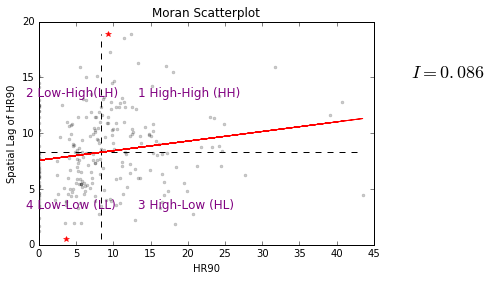

In [12]:
plt.plot(sigs, W_sigs, '*',markerfacecolor='r', markeredgecolor='r')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), Lag_HR90.min(), Lag_HR90.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_HR90.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.text(s='$I = %.3f$' % I_HR90.I, x=50, y=15, fontsize=18)
plt.text(s='1 High-High (HH)', x=HR90.mean()+5, y=Lag_HR90.mean()+5, fontsize=12,color="purple")
plt.text(s='3 High-Low (HL)', x=HR90.mean()+5, y=Lag_HR90.mean()-5, fontsize=12,color="purple")
plt.text(s='2 Low-High(LH)', x=HR90.mean()-10, y=Lag_HR90.mean()+5, fontsize=12,color="purple")
plt.text(s='4 Low-Low (LL)', x=HR90.mean()-10, y=Lag_HR90.mean()-5, fontsize=12,color="purple")
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

We can also make a LISA map of the data. 

In [13]:
sig = LMo_HR90.p_sim < 0.05

In [14]:
sig.sum()

43

In [15]:
LMo_HR90.q

array([3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,
       2, 4, 1, 2, 4, 4, 1, 2, 3, 3, 3, 2, 4, 3, 3, 4, 4, 4, 2, 1, 2, 2, 2,
       4, 3, 3, 4, 3, 3, 3, 1, 4, 2, 2, 1, 2, 4, 3, 3, 3, 3, 4, 2, 4, 3, 3,
       3, 2, 2, 4, 4, 2, 3, 3, 1, 1, 2, 4, 3, 3, 3, 3, 3, 4, 3, 3, 2, 4, 1,
       2, 1, 1, 4, 3, 3, 1, 4, 4, 4, 4, 3, 3, 3, 3, 3, 1, 2, 1, 1, 3, 1, 3,
       3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 1, 3, 1, 1, 2, 3, 1, 2, 4, 4, 1, 2,
       3, 2, 3, 3, 1, 2, 3, 3, 2, 2, 1, 4, 2, 1, 2, 3, 3, 3, 1, 1, 3, 4, 4,
       2, 1, 3, 1, 2, 1, 2, 4, 1, 2, 3, 3, 4, 2, 2, 1, 3, 3, 1, 1, 1, 2, 1,
       3, 1, 4, 2, 2, 4, 1, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 4, 2, 2,
       2, 2, 1, 1, 2, 1, 4, 1, 1, 3, 1, 2, 2, 1, 1, 1, 3, 2, 4, 3, 3, 1, 1,
       2, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 4, 3, 1, 1, 2, 3, 1, 3, 3,
       4])

In [16]:
hotspots = LMo_HR90.q==1 * sig

In [17]:
hotspots.sum()

9

In [18]:
coldspots = LMo_HR90.q==3 * sig

In [19]:
coldspots.sum()

17

In [20]:
data.HR90[hotspots]

98      9.784698
132    11.435106
164    17.129154
209    13.274924
229    12.371338
234    31.721863
236     9.584971
239     9.256549
242    18.062652
Name: HR90, dtype: float64

In [21]:
data[hotspots]

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
98,Ellis,Texas,48,139,48139,48,139,48139,1,9.217652,...,10.009746,0.325785,0.365177,0.352516,0.372783,12.418831,10.5,9.076165,12.031635,<pysal.cg.shapes.Polygon object at 0x11d45e110>
132,Hudspeth,Texas,48,229,48229,48,229,48229,1,9.971084,...,0.514580,0.312484,0.373474,0.440944,0.476631,14.115899,7.7,8.959538,11.363636,<pysal.cg.shapes.Polygon object at 0x11d46f250>
164,Jeff Davis,Texas,48,243,48243,48,243,48243,1,0.000000,...,0.359712,0.316019,0.367719,0.437014,0.399655,14.438503,10.1,5.970149,8.255159,<pysal.cg.shapes.Polygon object at 0x11d48d290>
209,Chambers,Texas,48,071,48071,48,71,48071,1,3.211613,...,12.694146,0.299847,0.374105,0.378431,0.364723,9.462037,9.2,8.568120,10.598911,<pysal.cg.shapes.Polygon object at 0x11d4a5890>
229,Frio,Texas,48,163,48163,48,163,48163,1,3.296414,...,1.358373,0.390980,0.463020,0.435098,0.473507,14.665445,9.4,11.842919,18.330362,<pysal.cg.shapes.Polygon object at 0x11d4bf350>
234,La Salle,Texas,48,283,48283,48,283,48283,1,0.000000,...,1.008755,0.421556,0.482174,0.489173,0.492687,18.167702,14.1,13.052937,20.088626,<pysal.cg.shapes.Polygon object at 0x11d4bf5d0>
236,Dimmit,Texas,48,127,48127,48,127,48127,1,0.000000,...,0.575098,0.417976,0.452789,0.456840,0.479503,13.826043,10.1,10.944363,17.769080,<pysal.cg.shapes.Polygon object at 0x11d4bf6d0>
239,Webb,Texas,48,479,48479,48,479,48479,1,2.057899,...,0.117083,0.382594,0.443082,0.439100,0.461075,20.292824,15.5,17.419676,20.521271,<pysal.cg.shapes.Polygon object at 0x11d4bf950>
242,Duval,Texas,48,131,48131,48,131,48131,1,2.487934,...,0.092894,0.370217,0.427660,0.421041,0.458937,15.829478,13.2,12.803677,20.699881,<pysal.cg.shapes.Polygon object at 0x11d4bfb50>


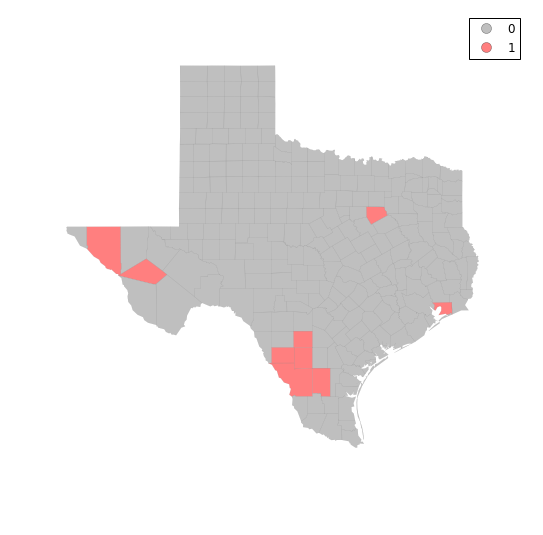

In [22]:
from matplotlib import colors
import geopandas as gpd
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
shp_link = "data/texas.shp"
tx = gpd.read_file(shp_link)
tx.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [23]:
data.HR90[coldspots]

0      0.000000
3      0.000000
4      3.651767
5      0.000000
13     5.669899
19     3.480743
21     3.675119
32     2.211607
33     4.718762
48     5.509870
51     0.000000
62     3.677958
69     0.000000
81     0.000000
87     3.699593
140    8.125292
233    5.304688
Name: HR90, dtype: float64

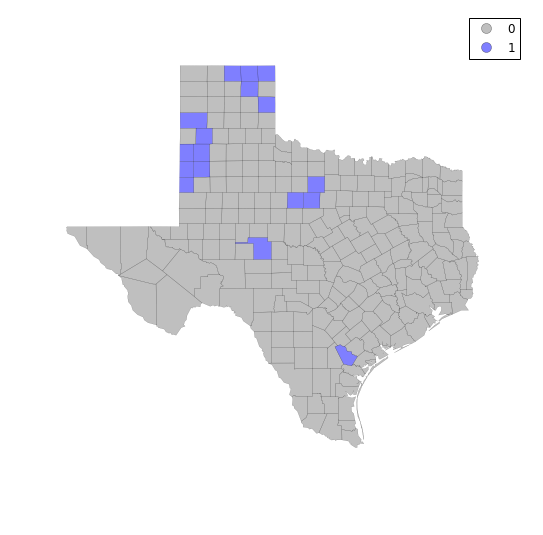

In [24]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()


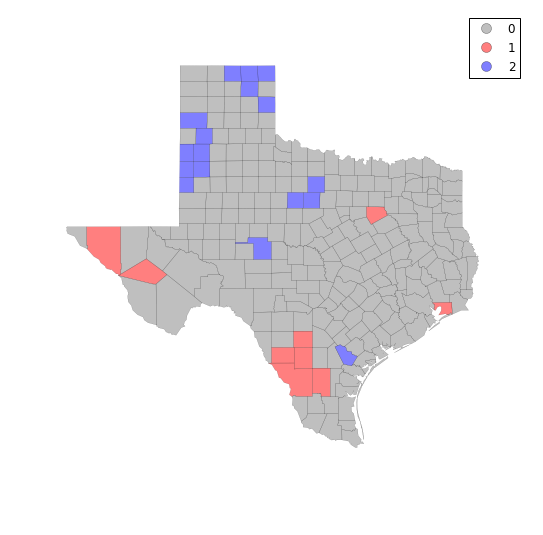

In [25]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

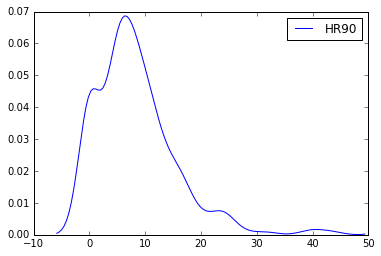

In [26]:
import seaborn as sns
sns.kdeplot(data.HR90)

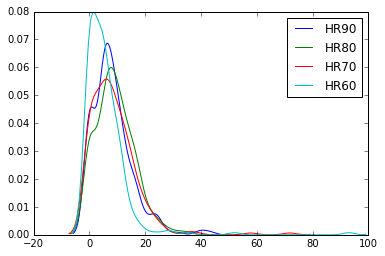

In [27]:
sns.kdeplot(data.HR90)
sns.kdeplot(data.HR80)
sns.kdeplot(data.HR70)
sns.kdeplot(data.HR60)

In [28]:
data.HR90.mean()

8.302494460285041

In [29]:
data.HR90.median()

7.23234613355

## Exercises

1. Repeat the local analysis for the years 1960, 70, 80 and compare the results to what we found in 1990.
2. How many counties are hot spots in each of the periods?

## Solutions

In [30]:
np.random.seed(12345)
I_pv = [ps.Moran(data[var].values, W).p_sim for var in ['HR60', 'HR70', 'HR80', 'HR90']]
I_pv

[0.121, 0.002, 0.001, 0.016]

In [31]:
LMs = [ps.Moran_Local(data[var].values, W) for var in ['HR60', 'HR70', 'HR80', 'HR90']]


In [32]:
#sig = LMo_HR90.p_sim < 0.05
#hotspots = LMo_HR90.q==1 * sig

hotspots = np.array([ (LM.p_sim < 0.05)*(LM.q==1) for LM in LMs]).T

In [33]:
hotspots.sum(axis=0)

array([ 6, 15, 22,  9])

In [34]:
hotspots.sum(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [35]:
hotspots.sum(axis=1).max()

2

In [36]:
data[hotspots.sum(axis=1)==2][['NAME','HR60','HR70', 'HR80','HR90']]

,NAME,HR60,HR70,HR80,HR90
72,Cass,9.930768,11.049876,7.928418,11.117782
93,Harrison,13.890717,16.354081,15.944386,8.698224
98,Ellis,9.217652,17.868119,12.274799,9.784698
108,Rusk,10.982675,16.616816,17.721070,9.145993
109,Panola,1.975894,23.069502,12.867529,0.000000
185,Montgomery,7.451842,10.778984,12.193192,11.525733
190,Liberty,12.660231,16.154763,22.652622,11.379585
